In [ ]:
"""import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/projects"""


'import os\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "/content/drive/MyDrive/projects'

In [ ]:
#!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

In [ ]:
#! kaggle datasets list

In [1]:
%cd /content/drive/MyDrive/projects/Plant Weed Classifier

/content/drive/MyDrive/projects/Plant Weed Classifier


In [2]:
import os
from torchvision import datasets

from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:

batch_size = 20
num_workers = 0

data_dir = './data'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

In [4]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [5]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [6]:

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [7]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_classes = 12


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
import pickle
model_scratch = Net()
pickle.dump(model_scratch,open("./model_arc.pkl","wb"))

In [10]:
use_cuda = torch.cuda.is_available()

if use_cuda:
  model_scratch.cuda()
  print("Trainig on GPU")
else:
  print("Training on CPU")

Training on CPU


In [11]:
model_scratch = pickle.load(open("./model_arc.pkl","rb"))

In [12]:
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=12, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [13]:
import torch.optim as optim


criterion_scratch = nn.CrossEntropyLoss()


optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
       
        train_loss = 0.0
        valid_loss = 0.0
        
        ######################
        # training the model #
        ######################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [15]:
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch 1, Batch 1 loss: 2.491212
Epoch 1, Batch 101 loss: 2.428730
Epoch 1, Batch 201 loss: 2.402961
Epoch: 1 	Training Loss: 2.393564 	Validation Loss: 2.165289
Validation loss decreased (inf --> 2.165289).  Saving model ...
Epoch 2, Batch 1 loss: 2.190752
Epoch 2, Batch 101 loss: 2.215658
Epoch 2, Batch 201 loss: 2.174178
Epoch: 2 	Training Loss: 2.167169 	Validation Loss: 2.499990
Epoch 3, Batch 1 loss: 2.752433
Epoch 3, Batch 101 loss: 2.027704
Epoch 3, Batch 201 loss: 2.008464
Epoch: 3 	Training Loss: 1.999175 	Validation Loss: 1.893456
Validation loss decreased (2.165289 --> 1.893456).  Saving model ...
Epoch 4, Batch 1 loss: 1.916587
Epoch 4, Batch 101 loss: 1.913307
Epoch 4, Batch 201 loss: 1.891666
Epoch: 4 	Training Loss: 1.890016 	Validation Loss: 1.536532
Validation loss decreased (1.893456 --> 1.536532).  Saving model ...
Epoch 5, Batch 1 loss: 1.673111
Epoch 5, Batch 101 loss: 1.837282
Epoch 5, Batch 201 loss: 1.778363
Epoch: 5 	Training Loss: 1.769374 	Validation Loss: 1.

In [29]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.377312


Test Accuracy: 84% (479/565)


In [16]:
import pickle
import torch
import torchvision

In [17]:
model = pickle.load(open("/content/drive/MyDrive/projects/Plant Weed Classifier/model_arc.pkl","rb"))

In [18]:
checkpoint = torch.load(r"model_scratch.pt",map_location=torch.device('cpu'))

In [19]:

model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
"""class_names = [
 'Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'ShepherdтАЩs Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']"""
class_names = [names for names in loaders_scratch['train'].dataset.classes]

In [21]:
from PIL import Image
import torchvision.transforms as transforms

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [22]:
def predict_image(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [23]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    prediction = predict_image(model, class_names, img_path)
        
    return prediction

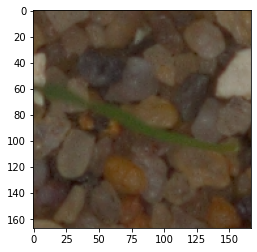

'Loose Silky-bent'

In [28]:
run_app("/content/drive/MyDrive/projects/Plant Weed Classifier/data/test/Black-grass/107.png")